In [1]:
import os
import math
import keras
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.optimizers import Adam
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB1
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report


2024-07-03 14:43:44.210527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 14:43:44.210602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 14:43:44.212339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape of raw Lenses: (3, 237, 239)
Shape of Lenses (g-band): (128, 128)
Shape of Lenses (r-band): (128, 128)
Shape of Lenses (i-band): (128, 128)
New Shape of Lenses (all bands): (128, 128, 3)
Shape of raw Non Lenses: (3, 239, 239)
Shape of Non Lenses (g-band): (128, 128)
Shape of Non Lenses (r-band): (128, 128)
Shape of Non Lenses (i-band): (128, 128)
New Shape of Non Lenses (all bands): (128, 128, 3)


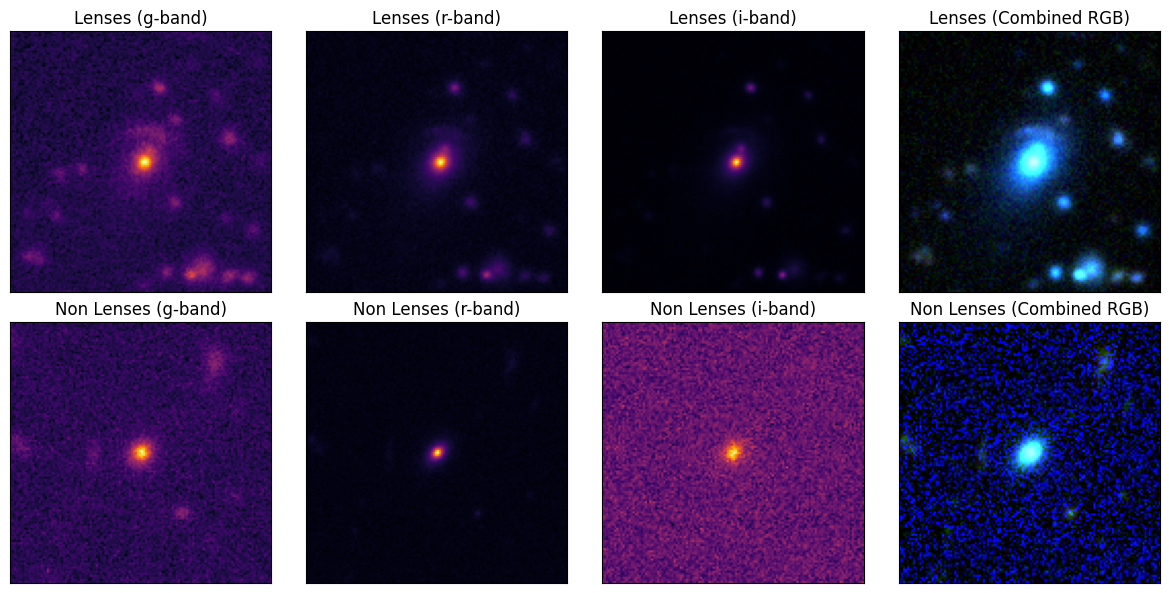

In [2]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

channel_names = ['g-band', 'r-band', 'i-band', 'Combined RGB']

for i, (folder_path, title) in enumerate([
    ('/kaggle/input/real-dataset-cleaned/dataset/lenses', 'Lenses'),
    ('/kaggle/input/real-dataset-cleaned/dataset/nonlenses', 'Non Lenses')]):
    file_name = os.listdir(folder_path)[7]
    file_path = os.path.join(folder_path, file_name)
    loaded_file = np.load(file_path, allow_pickle=True)
    print(f'Shape of raw {title}: {loaded_file.shape}')

    cropped_images = []

    if loaded_file.ndim == 3:
        for j in range(3): 
            img_channel = loaded_file[j]  # Select channel
            crop_size_x, crop_size_y = 128, 128
            if img_channel.shape[0] < 128 or img_channel.shape[1] < 128:
                crop_size_x = min(img_channel.shape[0], 128)
                crop_size_y = min(img_channel.shape[1], 128)
            cropped_image = crop_center(img_channel, crop_size_x, crop_size_y)
            cropped_images.append(cropped_image)  # Store the cropped image
            print(f'Shape of {title} ({channel_names[j]}): {cropped_image.shape}')
            axs[i, j].imshow(cropped_image, cmap='inferno')
            axs[i, j].set_title(f"{title} ({channel_names[j]})")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

        rgb_image = np.dstack(cropped_images)  # Stack along the third dimension to form an RGB image
        print(f'New Shape of {title} (all bands): {rgb_image.shape}')
        axs[i, 3].imshow(rgb_image)
        axs[i, 3].set_title(f"{title} (Combined RGB)")
        axs[i, 3].set_xticks([])
        axs[i, 3].set_yticks([])

    else:
        raise ValueError("Unexpected image data format")

plt.tight_layout()
plt.show()

In [3]:
# Algorithm hyperparameters
input_shape = (128, 128, 3)
num_epochs = 20
batch_size = 256 
width = 128
temperature = 0.1
queue_size = 10000

contrastive_augmentation_rotation = {"factor": 0.5,"name": "contrastive_augmenter_rotation"}
contrastive_augmentation_gaussian = {"std_dev": 0.1,"name": "contrastive_augmenter_gaussian"} # Std_dev = 0.04 for rgb and 0.001 for 1 channel


# classification_augmentation = {"brightness": 0.1,"name": "classification_augmenter","scale": (0.5, 3.0),}

# total_samples = sum([len(files) for r, d, files in os.walk(data_path)])
# steps_per_epoch = total_samples // batch_size
# validation_steps = total_samples // batch_size


In [4]:
classes = ['lenses', 'nonlenses']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}


def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

def image_generator(files, label_type, batch_size):
    while True:
        batch_paths = np.random.choice(a=files, size=batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            class_name = os.path.basename(os.path.dirname(input_path))
            label = class_indices[class_name]

            loaded_file = np.load(input_path)
            if loaded_file.ndim == 3 and loaded_file.shape[0] == 3:  # Check if the loaded file is correct
                # Create an RGB image by stacking the bands
                img_processed = np.dstack([crop_center(loaded_file[i], 128, 128) for i in range(3)])
            else:
                raise ValueError("Unexpected image data format")

            # Check for zero variance in the image
            if np.all(img_processed == img_processed[0, 0, 0]):
                print(f"\nSkipping image {input_path} due to no variation in pixels.")
                continue  # Skip this image in the loop

            # Normalize the image
            img_processed = (img_processed - np.min(img_processed)) / (np.max(img_processed) - np.min(img_processed))

            batch_input.append(img_processed)
            batch_output.append(label)

        if not batch_input or not batch_output:  # Check if lists are empty
            continue  # This ensures the generator does not yield empty arrays

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        if label_type == 'one_hot':
            batch_y = to_categorical(batch_y, num_classes=len(classes))

        yield (batch_x, batch_y)

data_path = '/kaggle/input/real-dataset-cleaned/dataset/'
batch_size = 128 
file_paths = []
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]

train_files, test_files = train_test_split(file_paths, test_size=0.1, random_state=69)

train_generator_one_hot = image_generator(train_files, label_type='one_hot', batch_size=batch_size)
test_generator_one_hot = image_generator(test_files, label_type='one_hot', batch_size=batch_size)

train_generator_label = image_generator(train_files, label_type='label', batch_size=batch_size)
test_generator_label = image_generator(test_files, label_type='label', batch_size=batch_size)

total_samples = len(train_files)
steps_per_epoch = total_samples // batch_size
total_validation_samples = len(test_files)
validation_steps = total_validation_samples // batch_size

Normalized (0-1) Array Range: 0.0, 1.0
Sample Image of label: nonlenses: 


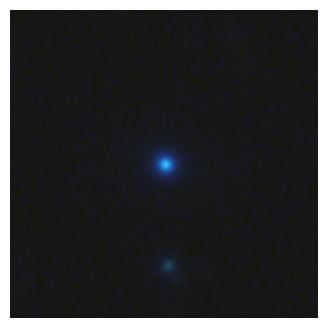

Image shape: (128, 128, 128, 3)
Label shape: (128, 2)


In [5]:
image_sample, label_sample = next(train_generator_one_hot)
print(f'Normalized (0-1) Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')
print(f'Sample Image of label: {"lenses" if np.argmax(label_sample[0]) == 0 else "nonlenses"}: ')
plt.figure(figsize=(4,4))
plt.imshow(image_sample[0])
# plt.imshow(np.mean(image_sample[0], axis=2), cmap='inferno') # np.mean() is used to convert the rgb image to greyscale so we can apply cmap to it.
plt.axis('off') 
plt.show()
print(f'Image shape: {image_sample.shape}\nLabel shape: {label_sample.shape}')


In [6]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images
    
class RandomGaussianNoise(layers.Layer):
    def __init__(self, std_dev):
        super().__init__()
        self.std_dev = std_dev

    def add_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0., stddev=self.std_dev)
        return tf.clip_by_value(images + noise, 0, 1)

    def call(self, images):
        images = self.add_gaussian_noise(images)
        return images

    
    
def get_augmenter_only_gaussian(std_dev, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            # layers.Rescaling(1 / 255), # Only for Single Channel Images
#             layers.RandomRotation(1), # Not needed for now
            RandomGaussianNoise(std_dev=std_dev),
#             RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
#             RandomBrightness(brightness=brightness),
        ],
        name=name,)

def get_augmenter_only_rotation(factor, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.RandomRotation(factor), 
        ],
        name=name,)

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness
    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)
    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness),)
    def call(self, images):
        images = self.random_brightness(images)
        return images 

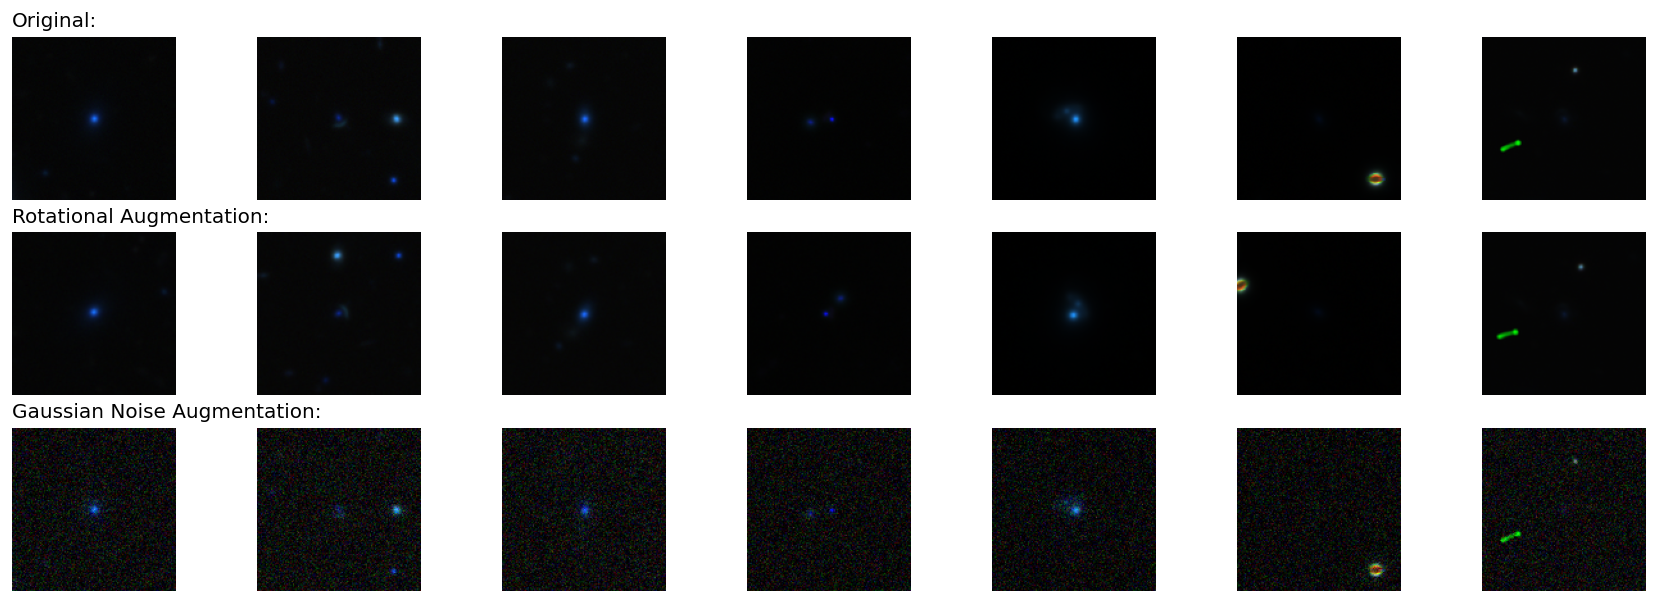

In [7]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(train_generator_one_hot)[0][:num_images]
    augmented_images = zip(
        images,
        get_augmenter_only_rotation(**contrastive_augmentation_rotation)(images),
        get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)(images),
    )
    row_titles = [
        "Original:",
        "Rotational Augmentation:",
        "Gaussian Noise Augmentation:",
    ]
    plt.figure(figsize=(18, 6), dpi=120)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(3, num_images, row * num_images + column + 1)
            plt.imshow(image, cmap='inferno')
#             plt.imshow(np.mean(image, axis=2), cmap='inferno')
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")

visualize_augmentations(num_images=7)

### Baseline Training


In [8]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
#     for layer in resnet.layers:
#         layer.trainable = False
    model = models.Sequential([
          resnet,
          layers.GlobalAveragePooling2D(),
          layers.Dense(width*8,  activation='relu'), #256*8 = 2048
          layers.BatchNormalization(), 
          layers.Dropout(0.5),
        
          layers.Dense(width*4,  activation='relu'), #256*4 = 1024
          layers.BatchNormalization(),
          layers.Dropout(0.5),
        
          layers.Dense(width,  activation='relu'), #512
          layers.BatchNormalization(),
          layers.Dropout(0.3),
    ])
    return model


In [9]:
baseline_model = keras.Sequential(
    [ 
        get_encoder(),
        layers.Dense(2, activation='softmax'),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

baseline_history = baseline_model.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                      validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20


I0000 00:00:1720017923.851337    1803 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720017923.953416    1803 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - acc: 0.5645 - auc: 0.5853 - loss: 1.0047

W0000 00:00:1720017937.827851    1801 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 537ms/step - acc: 0.5658 - auc: 0.5873 - loss: 1.0017 - val_acc: 0.5625 - val_auc: 0.5591 - val_loss: 0.6889
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - acc: 0.6555 - auc: 0.7249 - loss: 0.7737 - val_acc: 0.5156 - val_auc: 0.5144 - val_loss: 0.7283
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - acc: 0.7613 - auc: 0.8285 - loss: 0.5953 - val_acc: 0.4974 - val_auc: 0.4948 - val_loss: 0.7879
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - acc: 0.7753 - auc: 0.8413 - loss: 0.5871 - val_acc: 0.5859 - val_auc: 0.5838 - val_loss: 0.7165
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - acc: 0.8181 - auc: 0.8957 - loss: 0.4617 - val_acc: 0.5391 - val_auc: 0.5391 - val_loss: 0.7941
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - acc: 0.8300 - auc: 0.9041 - loss: 0.4537 - val_acc: 0.5052 - val_auc: 0.5039 - val_loss: 0.8869
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - acc: 0.8357 - auc: 0.9033 - loss: 0.4457 - val_acc: 0.

In [10]:
baseline_model.save_weights('baseline_model_resnet50.weights.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('baseline_history_resnet50.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

### Self-Supervised Contrastive Pretraining


c_loss: Contrastive loss. It is a measure of dissimilarity between pairs of augmented images. This loss is calculated using the InfoNCE (Information Noise-Contrastive Estimation) or NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which encourages similar representations for augmented views of the same image and dissimilar representations for different images.

c_acc: Contrastive accuracy. It measures the accuracy of the contrastive predictions. In this case, it represents how well the model is able to distinguish between the representations of augmented views of the same image and different images.

p_loss: Probe loss. It is the loss for the linear probe, which is used for evaluation and downstream classification tasks. The probe loss is calculated using the sparse categorical cross-entropy loss, comparing the predicted class probabilities with the true labels.

p_acc: Probe accuracy. It represents the accuracy of the linear probe, indicating how well the model performs on the downstream classification task.

### With only Rotational

In [ ]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_rotation(**contrastive_augmentation_rotation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(2)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=80, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,024 (129.00 KB)

 Trainable params: 33,024 (129.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "linear_probe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258 (1.01 KB)

 Trainable params: 258 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - c_acc: 0.0303 - c_loss: 4.4190 - p_acc: 0.5039 - p_loss: 0.6959 - val_p_acc: 0.5182 - val_p_loss: 0.7048
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - c_acc: 0.0707 - c_loss: 3.2004 - p_acc: 0.4982 - p_loss: 0.7118 - val_p_acc: 0.5260 - val_p_loss: 0.6928
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - c_acc: 0.1003 - c_loss: 2.9723 - p_acc: 0.5057 - p_loss: 0.6985 - val_p_acc: 0.4661 - val_p_loss: 0.6934
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - c_acc: 0.1137 - c_loss: 2.8506 - p_acc: 0.4673 - p_loss: 0.7043 - val_p_acc: 0.5130 - val_p_loss: 0.7527
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - c_acc: 0.1366 - c_loss: 2.7042 - p_acc: 0.4808 - p_loss: 0.7516 - val_p_acc: 0.4661 - val_p_loss: 0.7434
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - c_acc: 0.1426 - c_loss: 2.5606 - p_acc: 0.5156 - p_loss: 0.7048 - val_p_acc: 0.4844 - val_p_loss: 0.7180
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - c_acc

In [ ]:
pretraining_model.save_weights('pretraining_model_rotational.weights.h5')
with open('pretraining_history_rotational.pkl', 'wb') as file:
    pickle.dump(pretraining_history.history, file)

In [ ]:
finetuning_model_rotation = keras.Sequential(
    [
        pretraining_model.encoder,
        layers.Dense(2, activation='softmax'),
    ],
    name="finetuning_model_rotation",
)
finetuning_model_rotation.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

finetuning_history_rotation = finetuning_model_rotation.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_rotation.history["val_acc"]) * 100
    )
)

In [ ]:
finetuning_model_rotation.save_weights('finetuning_model_rotation.weights.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('finetuning_history_rotation.pkl', 'wb') as file:
    pickle.dump(finetuning_history_rotation.history, file)

### With Gaussian blur

In [ ]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(2)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model_gaussian = ContrastiveModel()
pretraining_model_gaussian.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=80, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history_gaussian.history["val_p_acc"]) * 100
    )
)

In [ ]:
pretraining_model_gaussian.save_weights('pretraining_model_gaussian.weights.h5')
with open('pretraining_history_gaussian.pkl', 'wb') as file:
    pickle.dump(pretraining_history_gaussian.history, file)


In [ ]:
finetuning_model_gaussian = keras.Sequential(
    [
        pretraining_model_gaussian.encoder,
        layers.Dense(2, activation='softmax'),
    ],
    name="finetuning_model",
)
finetuning_model_gaussian.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

finetuning_history_gaussian = finetuning_model_gaussian.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_gaussian.history["val_acc"]) * 100
    )
)

In [ ]:
finetuning_model_gaussian.save_weights('finetuning_model_gaussian.weights.h5')
with open('finetuning_history_gaussian.pkl', 'wb') as file:
    pickle.dump(finetuning_history_gaussian.history, file)


### Results

In [ ]:
with open("/kaggle/working/baseline_history_resnet50.pkl", "rb") as f:
    baseline_history = pickle.load(f)
with open("/kaggle/working/finetuning_history_rotation.pkl", "rb") as f:
    finetuning_history_rotation = pickle.load(f)
with open("/kaggle/working/finetuning_history_gaussian.pkl", "rb") as f:
    finetuning_history_gaussian = pickle.load(f)   

In [ ]:
def plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian):
    fig, axes = plt.subplots(2, 3, figsize=(20, 9), dpi=100)
    
    metric_keys = ["auc", "acc", "loss"]
    metric_names = ["auc", "acc", "loss"]
    
    # Plotting for Real Data Training
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[0,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_rotation[f"{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_gaussian[f"{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[0,i].legend(fontsize='large')
        axes[0,i].set_title(f"Real Dataset: Classification TRAIN {metric_name} during training")
        axes[0,i].set_xlabel("epochs")
        axes[0,i].set_ylabel(f"Training {metric_name}")

    # Plotting for Real Data Validation
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[1,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_rotation[f"val_{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_gaussian[f"val_{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[1,i].legend(fontsize='large')
        axes[1,i].set_title(f"Real Dataset: Classification VALIDATION {metric_name} during training")
        axes[1,i].set_xlabel("epochs")
        axes[1,i].set_ylabel(f"Validation {metric_name}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian)

In [ ]:
baseline_model.load_weights('/kaggle/working/baseline_model_resnet50.weights.h5')
finetuning_model_rotation.load_weights('/kaggle/working/finetuning_model_rotation.weights.h5')
finetuning_model_gaussian.load_weights('/kaggle/working/finetuning_model_gaussian.weights.h5')

In [ ]:
val_file_paths = []
for class_name in classes:
    val_class_dir = os.path.join('/kaggle/input/real-dataset-cleaned/dataset/' , class_name)
    val_file_paths += [os.path.join(val_class_dir, file) for file in os.listdir(val_class_dir)]
val_generator = image_generator(val_file_paths, label_type='one_hot', batch_size = batch_size)

# baseline_model_results = baseline_model.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_rotation_results = finetuning_model_rotation.predict(val_generator, steps=len(val_file_paths), verbose=1)
# finetuning_model_gaussian_results = finetuning_model_gaussian.predict(val_generator, steps=len(val_file_paths), verbose=1)

In [ ]:
num_batches = len(val_file_paths) // batch_size

y_true_baseline = []
y_pred_baseline = []
y_true_finetuning_rotation = []
y_pred_finetuning_rotation = []
y_true_finetuning_gaussian = []
y_pred_finetuning_gaussian = []

for i in range(num_batches):
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

# Here is the extra logic for handling the last smaller batch
if len(val_file_paths) % batch_size != 0:
    X_batch, y_batch = next(val_generator)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning_rotation = np.array(y_true_finetuning_rotation)
y_pred_finetuning_rotation = np.array(y_pred_finetuning_rotation)
y_true_finetuning_gaussian = np.array(y_true_finetuning_gaussian)
y_pred_finetuning_gaussian = np.array(y_pred_finetuning_gaussian)

In [ ]:
# Convert one hot encoded labels back to single integer labels for accuracy and classification report
y_true_baseline_int = np.argmax(y_true_baseline, axis=1)
y_pred_baseline_int = np.argmax(y_pred_baseline, axis=1)
y_true_finetuning_rotation_int = np.argmax(y_true_finetuning_rotation, axis=1)
y_pred_finetuning_rotation_int = np.argmax(y_pred_finetuning_rotation, axis=1)
y_true_finetuning_gaussian_int = np.argmax(y_true_finetuning_gaussian, axis=1)
y_pred_finetuning_gaussian_int = np.argmax(y_pred_finetuning_gaussian, axis=1)

# Calculate AUC
auc_baseline = roc_auc_score(y_true_baseline, y_pred_baseline, average='macro', multi_class='ovr')
auc_finetuning_rotation = roc_auc_score(y_true_finetuning_rotation, y_pred_finetuning_rotation, average='macro', multi_class='ovr')
auc_finetuning_gaussian = roc_auc_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian, average='macro', multi_class='ovr')

print("Separate test set results (Real Dataset: Containing 4000 samples per class):\n")
print(f"AUC (Baseline): {int(auc_baseline * 1000) / 1000}")  
print(f"AUC (Finetuning Rotation): {int(auc_finetuning_rotation * 1000) / 1000}") 
print(f"AUC (Finetuning Gaussian): {int(auc_finetuning_gaussian * 1000) / 1000}") 

# Calculate accuracy
accuracy_baseline = accuracy_score(y_true_baseline_int, y_pred_baseline_int)
accuracy_finetuning_rotation = accuracy_score(y_true_finetuning_rotation_int, y_pred_finetuning_rotation_int)
accuracy_finetuning_gaussian = accuracy_score(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int)

# Print classification report
print("\nReal Dataset: Classification Report (Baseline):")
print(classification_report(y_true_baseline_int, y_pred_baseline_int))
print("\nReal Dataset: Classification Report (Finetuning Rotation):")
print(classification_report(y_true_finetuning_rotation_int, y_pred_finetuning_rotation_int))
print("\nReal Dataset: Classification Report (Finetuning Gaussian):")
print(classification_report(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int))

In [ ]:
datasets = {
    "Resnet50 Baseline": (y_true_baseline, y_pred_baseline),
    "Finetuned with Rotation Pretext": (y_true_finetuning_rotation, y_pred_finetuning_rotation),
    "Finetuned with Gaussian Noise Pretext": (y_true_finetuning_gaussian, y_pred_finetuning_gaussian)
}

plt.figure(figsize=(12, 16)) 
for idx, (title, (y_true, y_pred)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.subplot(len(datasets), 2, 2*idx+1)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'Real Dataset: Confusion Matrix \n({title})', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=11)
    plt.ylabel('True Labels', fontsize=11)

    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, list(class_indices.keys()))
    plt.yticks(tick_marks, list(class_indices.keys()), rotation=90)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    # Calculate ROC Curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for key, value in class_indices.items():
        fpr[value], tpr[value], _ = roc_curve(y_true[:, value], y_pred[:, value])
        roc_auc[value] = auc(fpr[value], tpr[value])

    plt.subplot(len(datasets), 2, 2*idx+2)
    for class_name, idx in class_indices.items():
        plt.plot(fpr[idx], tpr[idx], label=f"{class_name} (AUC = {roc_auc[idx]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'Real Dataset: ROC \n({title})', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()


In [ ]:
# !cd /kaggle/working/
# !tar -czvf output.zip -C . .

<a href="output.zip"> Download File </a>